In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import random

import splitfolders
import pathlib
import cv2
import os
import PIL

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
ds_path = 'C:/Users/aa10098/Downloads/Rice/Rice_Image_Dataset_50'
ds_path = pathlib.Path(ds_path)

In [4]:
splitfolders.ratio(ds_path, output='imgs_50', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 250 files [00:02, 110.95 files/s]


In [6]:
arborio = [fn for fn in os.listdir(f'{ds_path}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{ds_path}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{ds_path}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{ds_path}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{ds_path}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = []
for i in os.listdir('imgs_50/train'):
    rice_classes+=[i]
rice_classes.sort()

Total images: 250
Total number of classes: 5
Total Arborio images: 50
Total Basmati images: 50
Total Ipsala images: 50
Total Jasmine images: 50
Total Karacadag images: 50


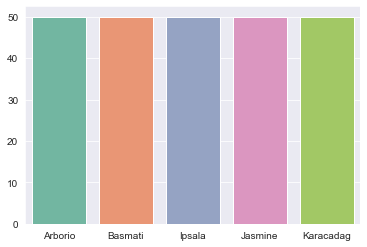

In [7]:
image_count = len(list(ds_path.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')
count = 0
rice_count = []
for x in rice_classes:
  print(f'Total {x} images: {len(rice[count])}')
  rice_count.append(len(rice[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x=rice_classes, y=rice_count, palette="Set2")
plt.show()

Rice Image Dimensions are: (250, 250, 3)


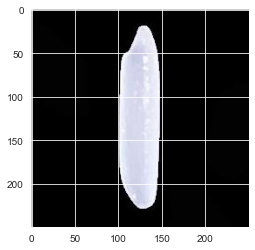

In [8]:
rice_img = cv2.imread('C:/Users/aa10098/Downloads/Rice/Rice_Image_Dataset_100/Basmati/basmati (14).jpg')
rice_img = cv2.cvtColor(rice_img, cv2.COLOR_BGR2RGB)
plt.imshow(rice_img)
print(f"Rice Image Dimensions are: {rice_img.shape}")

In [9]:
batch_size = 128
img_height, img_width = 175, 175
input_shape = (img_height, img_width, 3)

In [10]:
img_generator = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 30,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   fill_mode = 'nearest')

In [11]:
ds_train = img_generator.flow_from_directory('imgs_50/train',
                                             target_size = (img_height, img_width),
                                             batch_size = batch_size,
                                             subset = "training",
                                             class_mode='categorical')
ds_validate = img_generator.flow_from_directory('imgs_50/val',
                                          target_size = (img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode='categorical',
                                          shuffle=False)
ds_test = img_generator.flow_from_directory('imgs_50/test',
                                      target_size = (img_height, img_width),
                                      batch_size = batch_size,
                                      class_mode='categorical',
                                      shuffle=False)

Found 175 images belonging to 5 classes.
Found 35 images belonging to 5 classes.
Found 40 images belonging to 5 classes.


In [12]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = input_shape, activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(5))
model.add(Activation('softmax'))


In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 173, 173, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 173, 173, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 173, 173, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 173, 173, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 87, 87, 32)       0         
 )                                                               
                                                        

In [14]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [15]:
fitting = model.fit(ds_train, epochs = 40,  
                    validation_data = ds_validate,
                    callbacks = callbacks) 

Epoch 1/40
2/2 [==============================] - ETA: 0s - loss: 2.6834 - accuracy: 0.2514
Epoch 1: val_accuracy improved from -inf to 0.34286, saving model to saved_models\model_vanilla.hdf5
2/2 [==============================] - 22s 16s/step - loss: 2.6834 - accuracy: 0.2514 - val_loss: 1.5606 - val_accuracy: 0.3429 - lr: 0.0010
Epoch 2/40
2/2 [==============================] - ETA: 0s - loss: 1.7791 - accuracy: 0.3600 
Epoch 2: val_accuracy did not improve from 0.34286
2/2 [==============================] - 19s 6s/step - loss: 1.7791 - accuracy: 0.3600 - val_loss: 1.6238 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/40
2/2 [==============================] - ETA: 0s - loss: 1.1549 - accuracy: 0.5143
Epoch 3: val_accuracy did not improve from 0.34286
2/2 [==============================] - 19s 13s/step - loss: 1.1549 - accuracy: 0.5143 - val_loss: 1.8868 - val_accuracy: 0.2286 - lr: 0.0010
Epoch 4/40
2/2 [==============================] - ETA: 0s - loss: 1.1316 - accuracy: 0.5600 
Epoch

In [17]:
score1 = model.evaluate(ds_test, verbose=1)
print(f'Model Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')

1/1 [==============================] - 1s 998ms/step - loss: 2.2059 - accuracy: 0.2000
Model Vanilla Loss: 2.2058796882629395, Accuracy: 20.000000298023224


1/1 [==============================] - 1s 1s/step


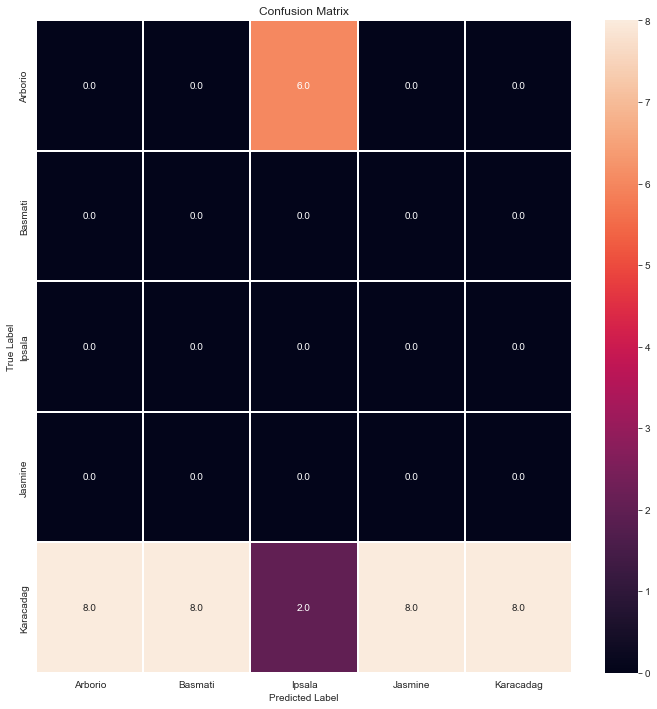

In [18]:
Y_pred = model.predict(ds_test)
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, ds_test.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(ds_test.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()